In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances, euclidean_distances
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import pearsonr
from skbio.stats.distance import mantel

In [3]:
params_to_work_with = constants.ALL_PARAMS
ctx_outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB', 'H023_IN', 'H061_SE']
pd_outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD004_KC']

In [29]:
def load_data(data_path, rois, outliers=[], data_cols=['subjects', 'Age', 'Gender'], remove_slopes=False):
    subjects_raw_data = DataProcessor(
        data_path, rois, rois, data_cols).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    
    if remove_slopes:
        chosen_data = chosen_data.drop(columns=constants.SLOPES)
        
    return chosen_data


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

def show_corr_mean(data_groups, clusters_rois):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    corr_means = []

    for (corr, title, color) in data_groups:
        corr_copy = corr.copy()
        np.fill_diagonal(corr_copy.values, 0)
        corr_mean = corr_copy.apply(np.mean, axis=1)
        corr_means.append(corr_mean)

        ax.scatter(clusters_rois, corr_mean.to_numpy(
        ), color=color, s=20, alpha=0.7, label=title)
        ax.plot(clusters_rois, corr_mean.to_numpy(), color=color)

        ax.set_xticks(clusters_rois)
        ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=8)


    # # Connecting the points with vertical lines
    # for x, y1, y2 in zip(clusters_rois, corr_mean1.to_numpy(), corr_mean2.to_numpy()):
    #     plt.plot([x, x], [y1, y2], color='gray', linestyle='--')

    # ax.set_facecolor('white')
    ax.grid(True)
    ax.legend()

    return corr_means

In [5]:
%autoreload 2

all_ctx_data_z_score= load_data(
    constants.PATH_TO_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    remove_slopes=True)

young_ctx_data_z_score, old_ctx_data_z_score = StatisticsWrapper.seperate_data_to_two_groups(
        all_ctx_data_z_score, 'Age', constants.AGE_THRESHOLD)
print(
    f'num young: {young_ctx_data_z_score.subjects.nunique()}, num old: {old_ctx_data_z_score.subjects.nunique()}')

pd_col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
all_pd_data_z_score= load_data(
    constants.PATH_TO_PD_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    data_cols=pd_col_names)

ctl_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'CTL']
ctl_old_data_z_score = ctl_data_z_score[ctl_data_z_score.Age >= constants.AGE_THRESHOLD]
ctl_young_data_z_score = ctl_data_z_score[ctl_data_z_score.Age < constants.AGE_THRESHOLD]
pd_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'PD']

print(
    f'num pd: {pd_data_z_score.subjects.nunique()}, num old ctl: {ctl_old_data_z_score.subjects.nunique()}, num young ctl: {ctl_young_data_z_score.subjects.nunique()}')

num young: 16, num old: 14
num pd: 32, num old ctl: 16, num young ctl: 3


In [6]:
print(f'mean age of old subjects: {old_ctx_data_z_score.Age.mean()}. mean age of control subjects: {ctl_data_z_score.Age.mean()}')
print(old_ctx_data_z_score.Age.min(), young_ctx_data_z_score.Age.max())

mean age of old subjects: 67.42857142857143. mean age of control subjects: 65.89473684210526
57 31


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


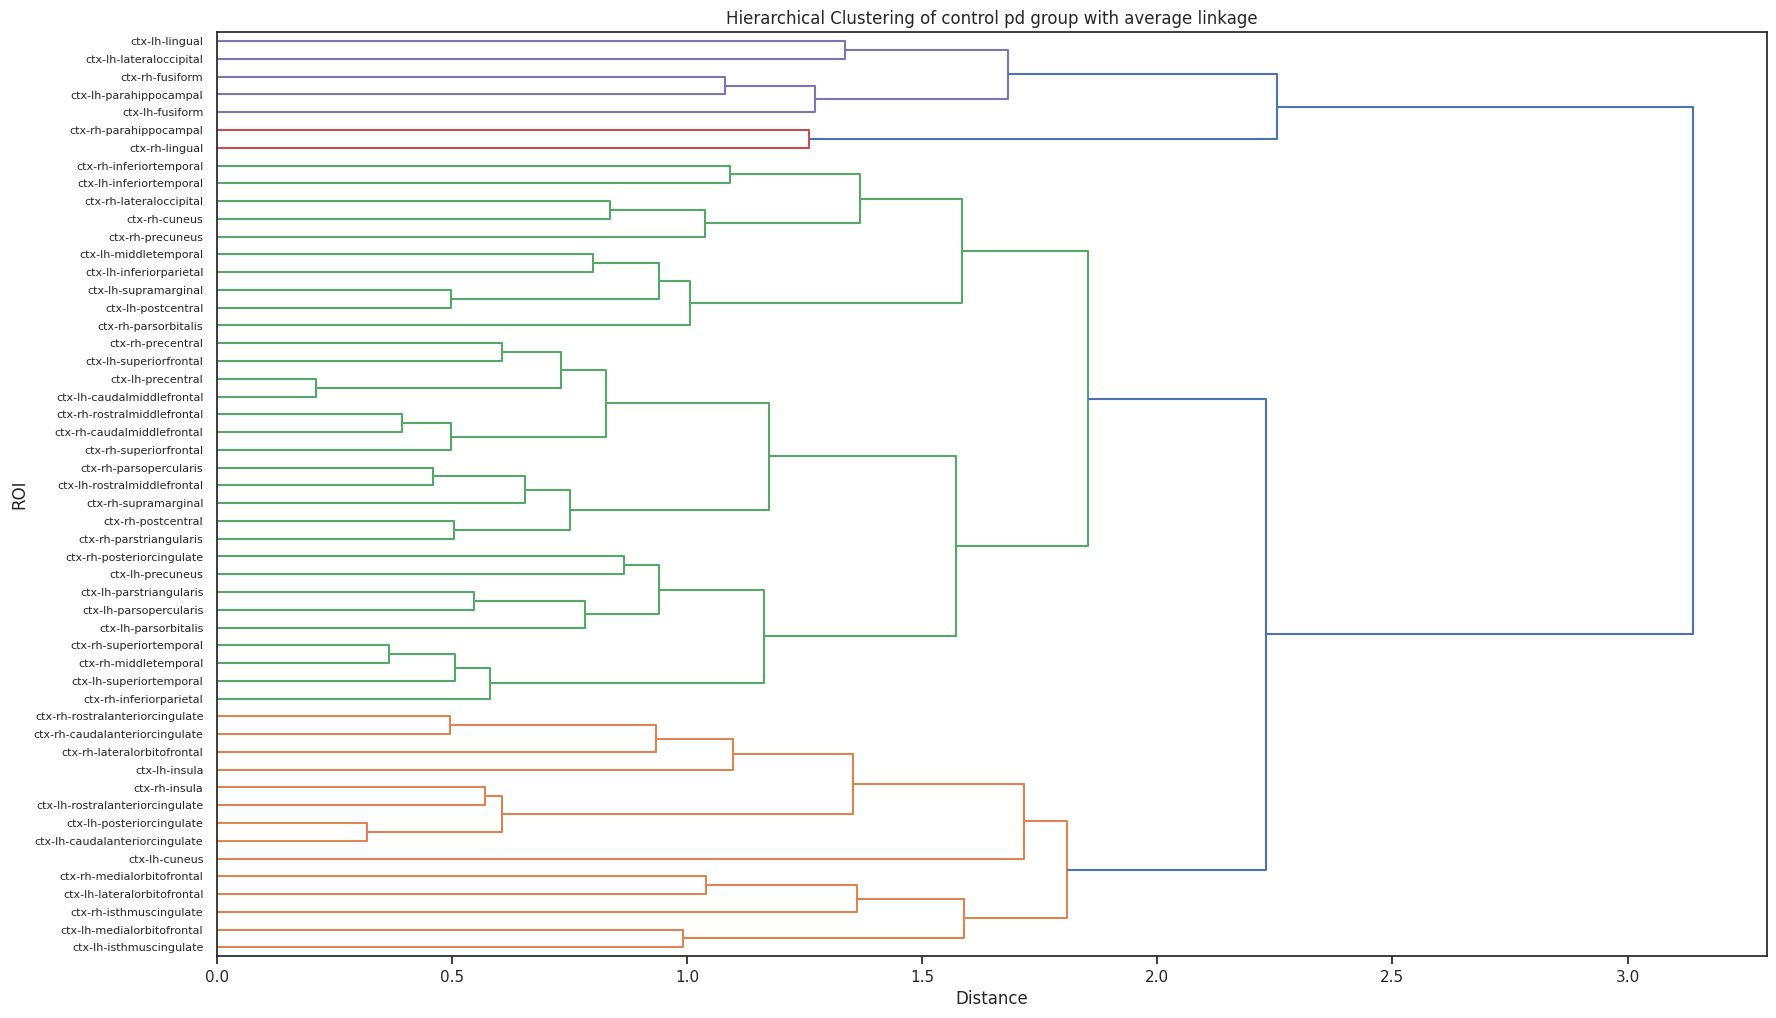

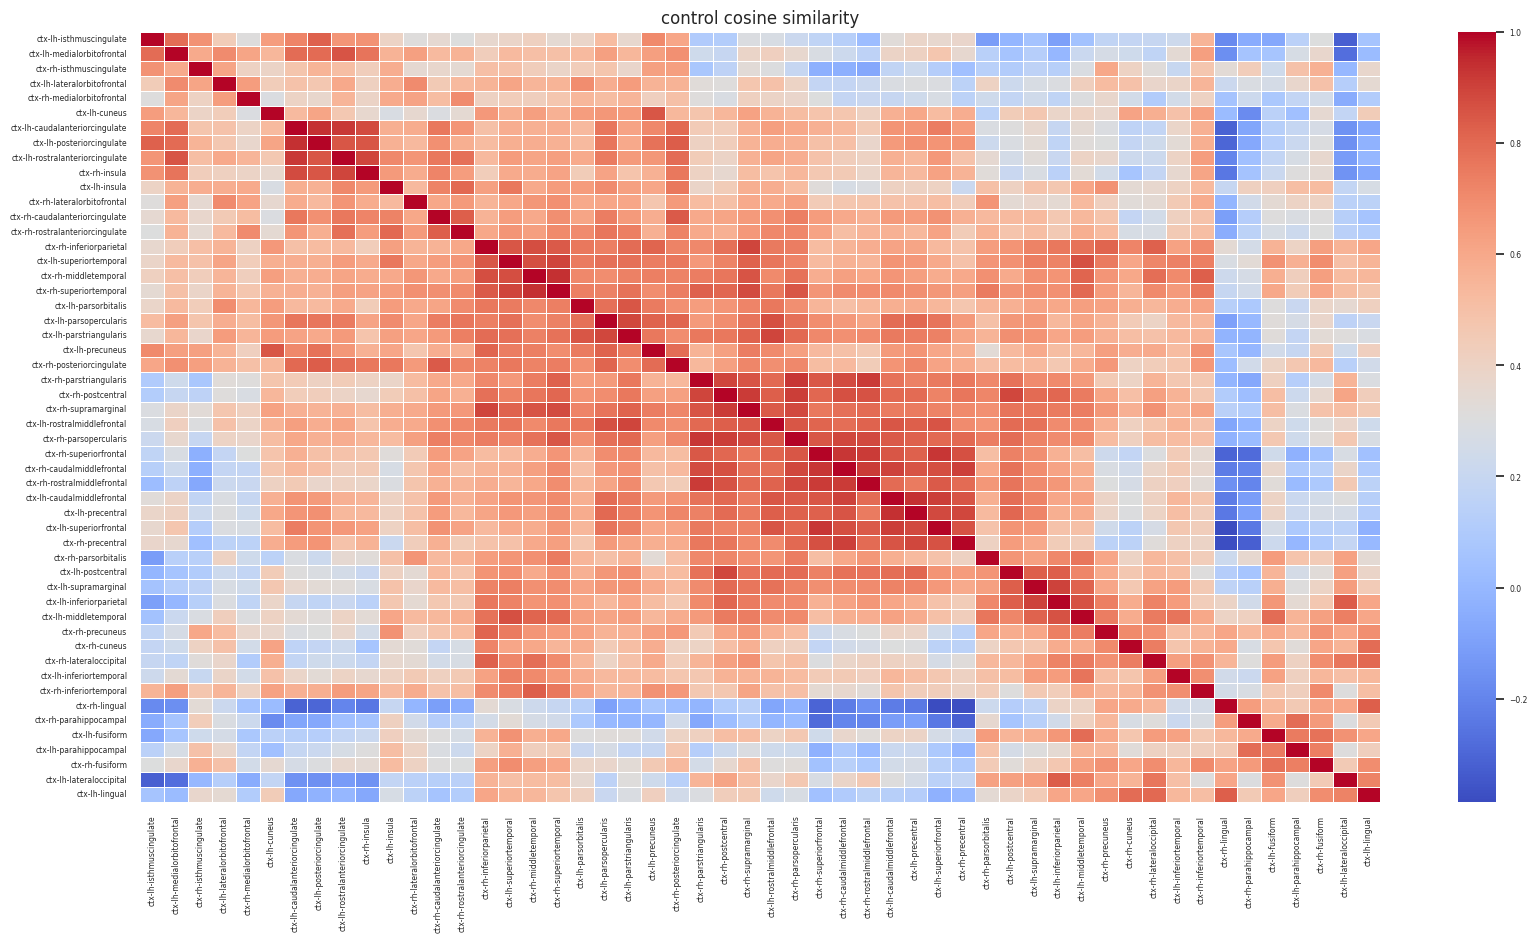

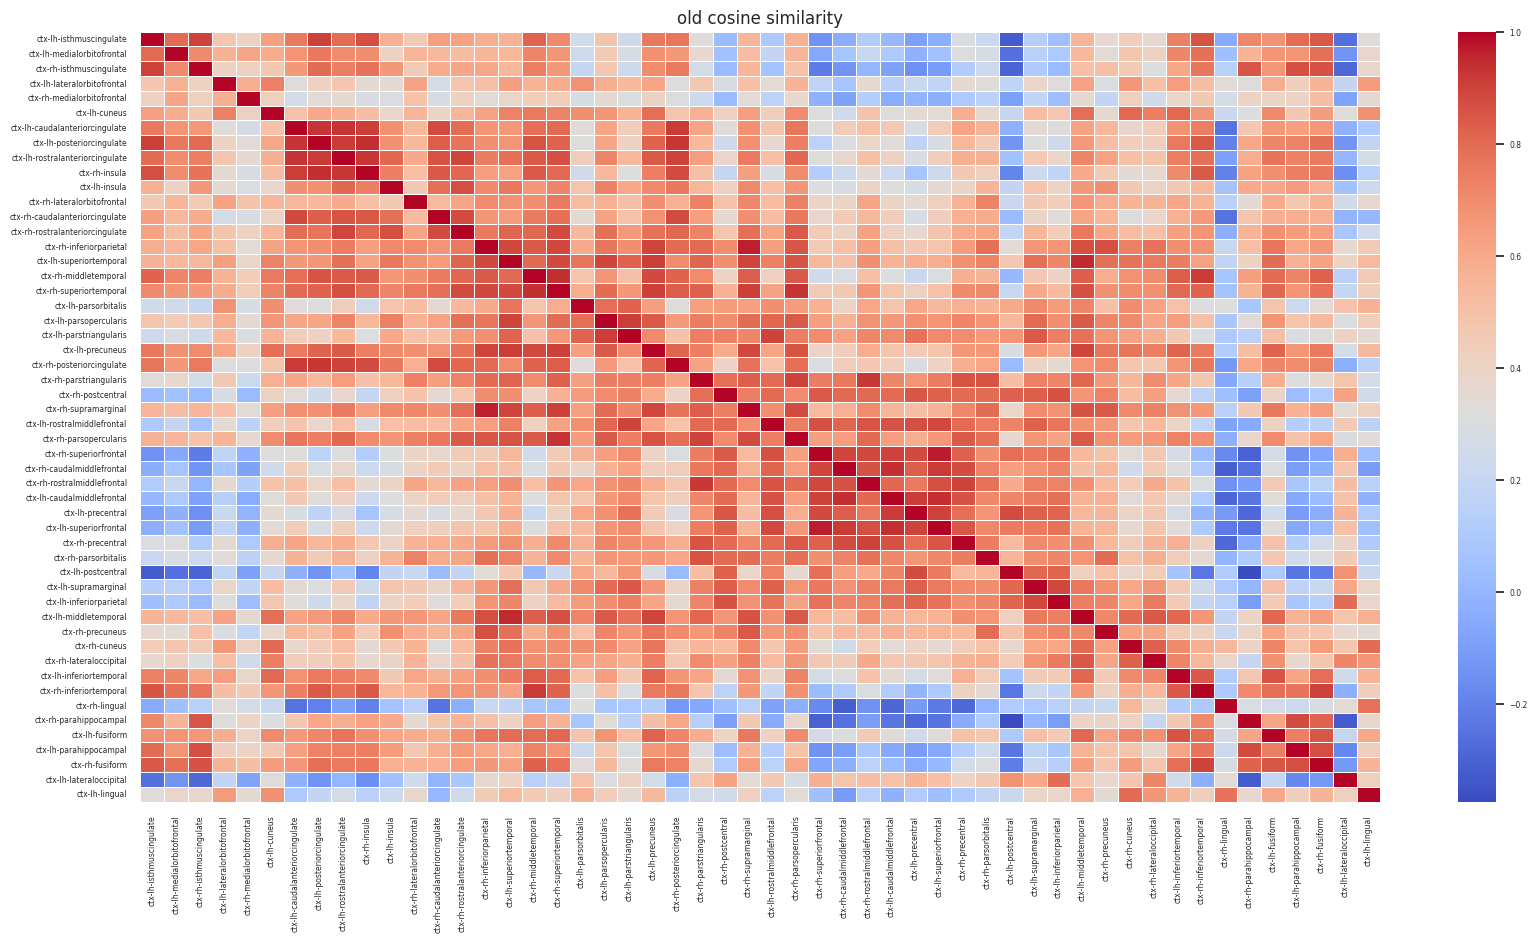

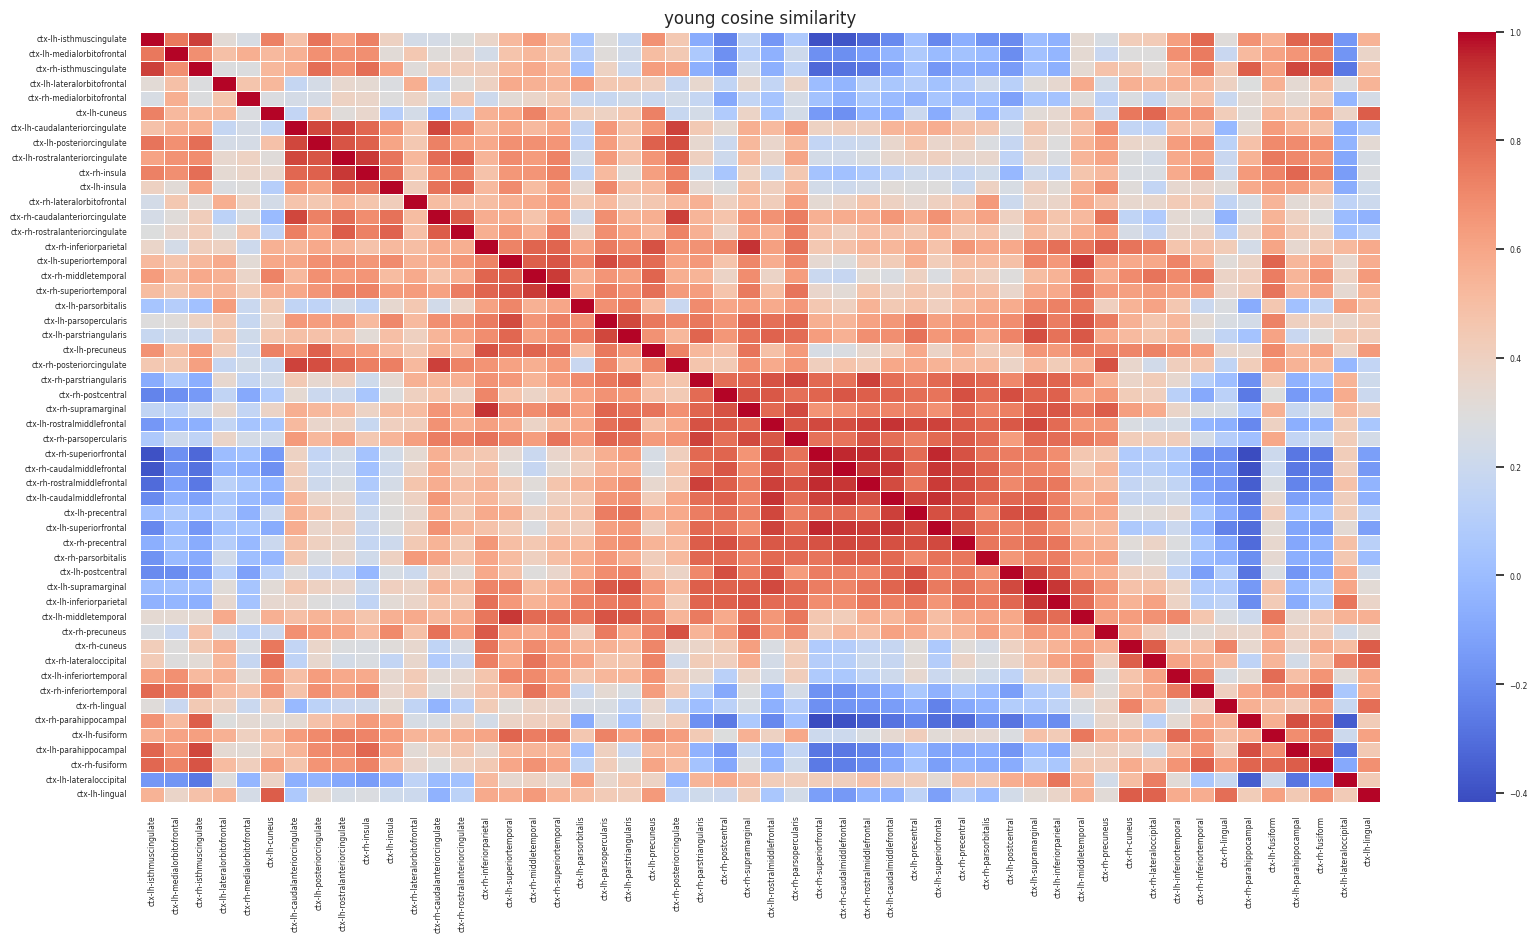

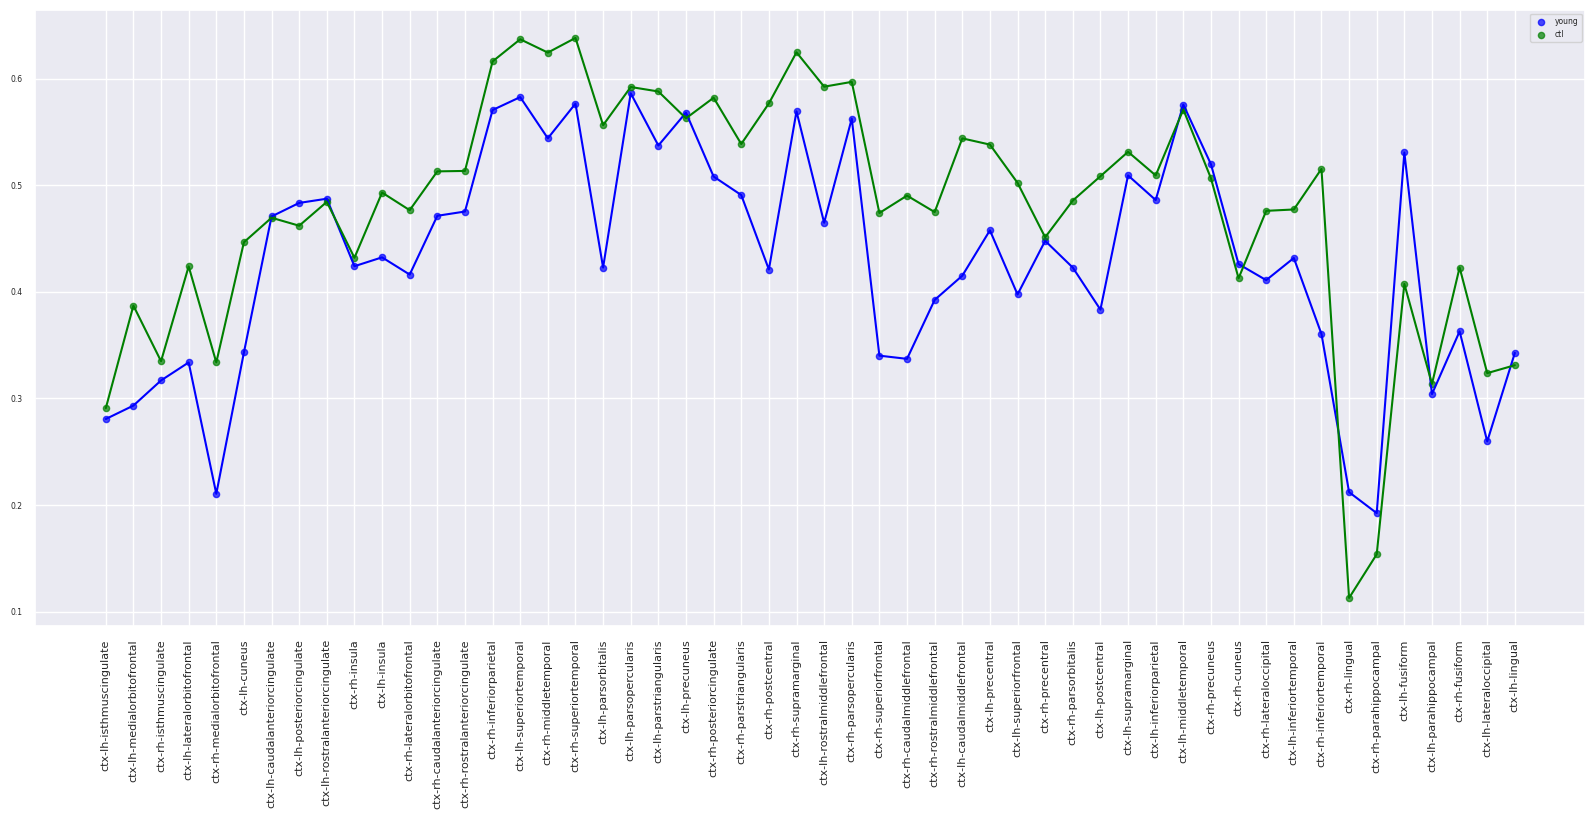

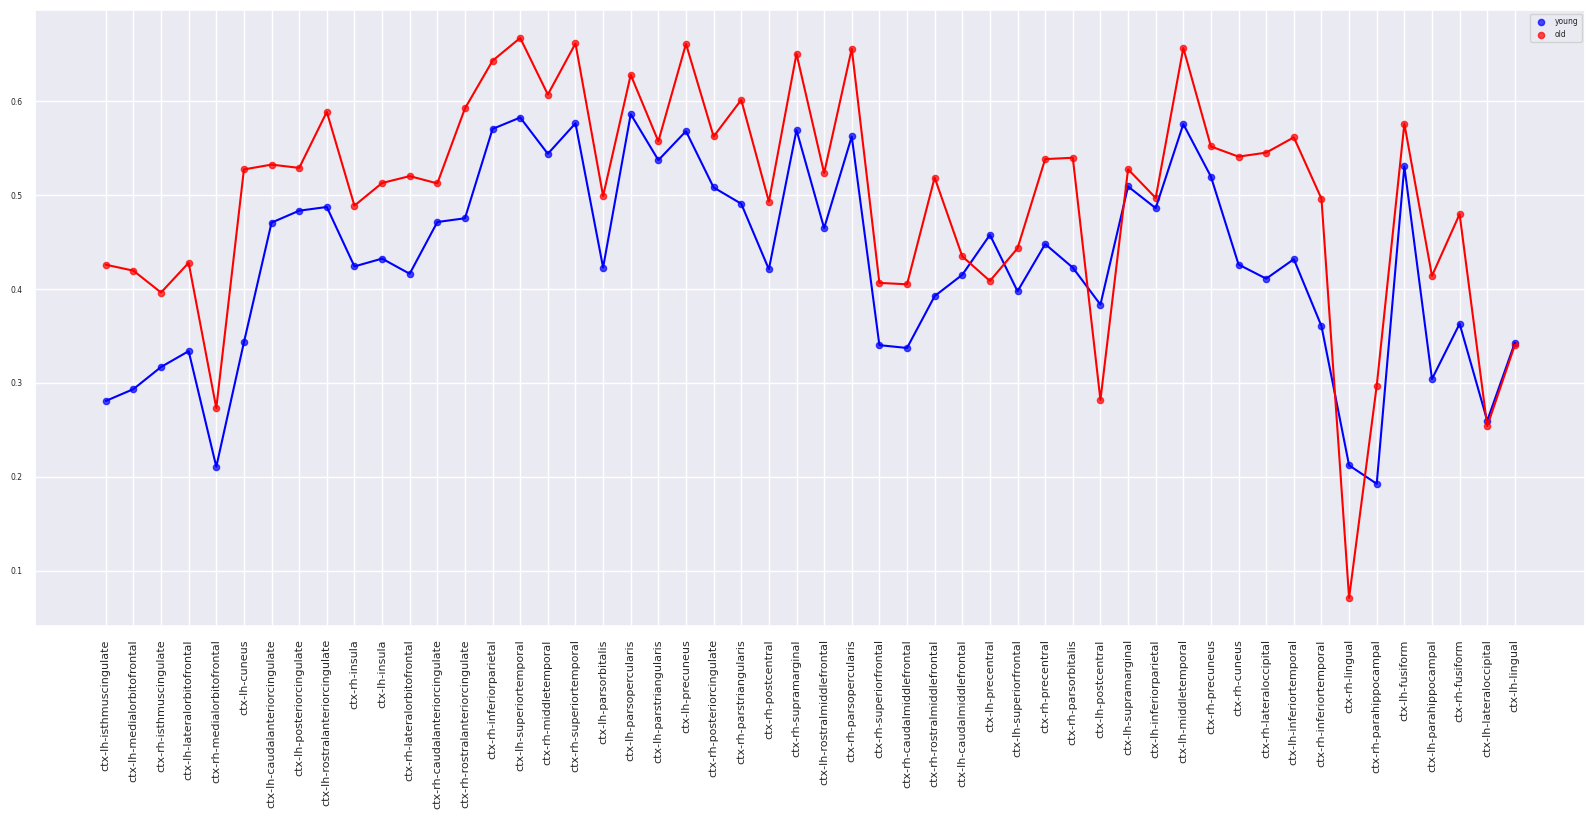

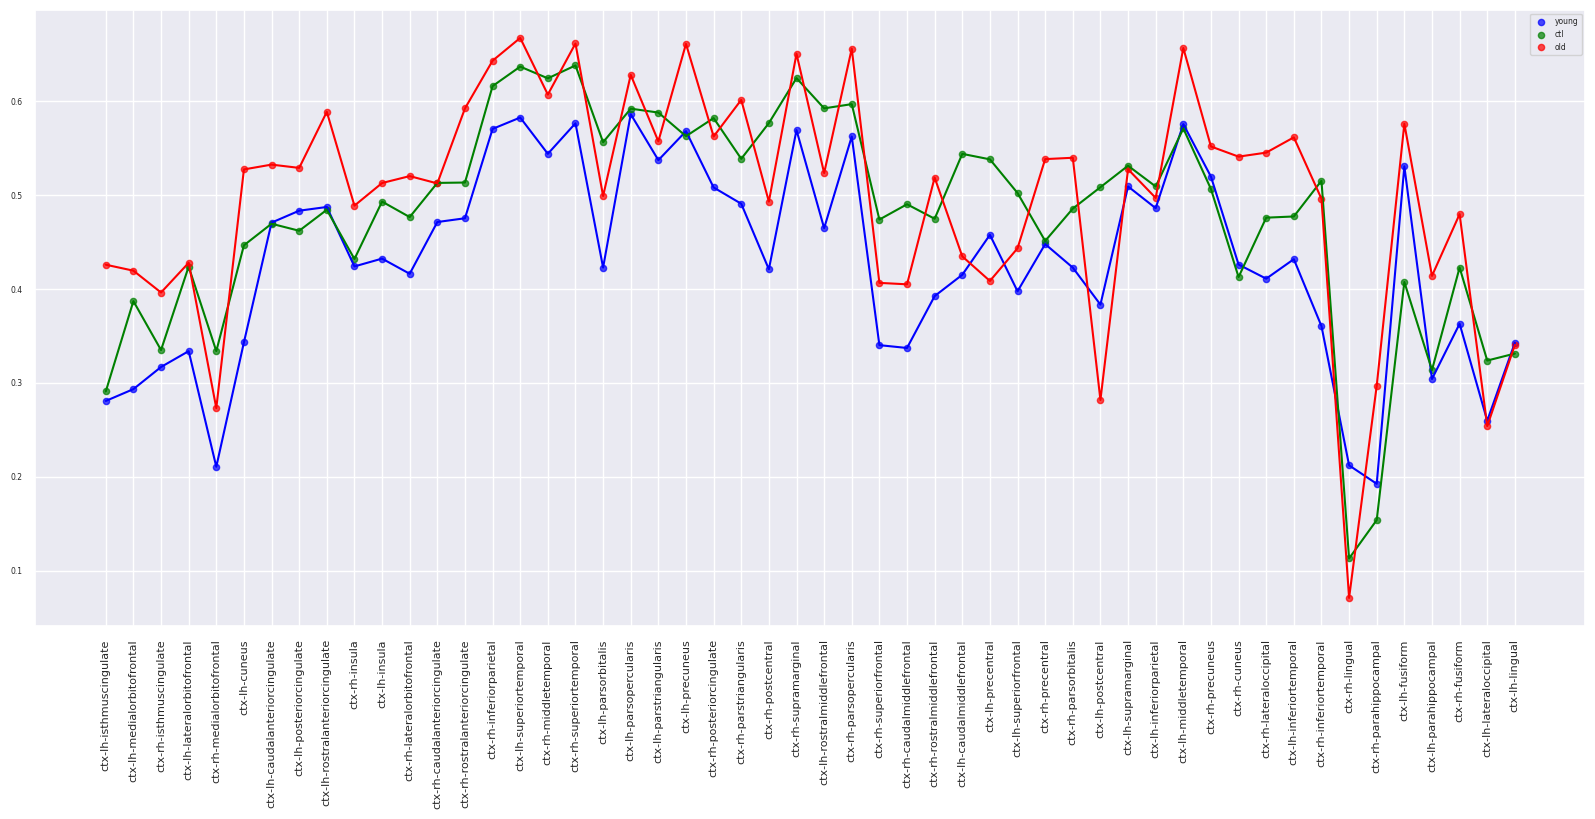

In [7]:
ctl_clustring_data =  StatisticsWrapper.hierarchical_clustering(ctl_data_z_score, params_to_work_with, 'average',
                                                            title="control pd")['dendrogram_data']['ivl']
ctl_distances = StatisticsWrapper.roi_distances(
    ctl_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'control cosine similarity')

old_distances = StatisticsWrapper.roi_distances(
    old_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'old cosine similarity')

young_distances = StatisticsWrapper.roi_distances(
    young_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'young cosine similarity')


_ = show_corr_mean([(young_distances, 'young', 'blue'), (ctl_distances, 'ctl', 'green')], ctl_clustring_data)
_ = show_corr_mean([(young_distances, 'young', 'blue'), (old_distances, 'old', 'red')], ctl_clustring_data)
_ = show_corr_mean([(young_distances, 'young', 'blue'), (ctl_distances, 'ctl', 'green'), (old_distances, 'old', 'red')], ctl_clustring_data)

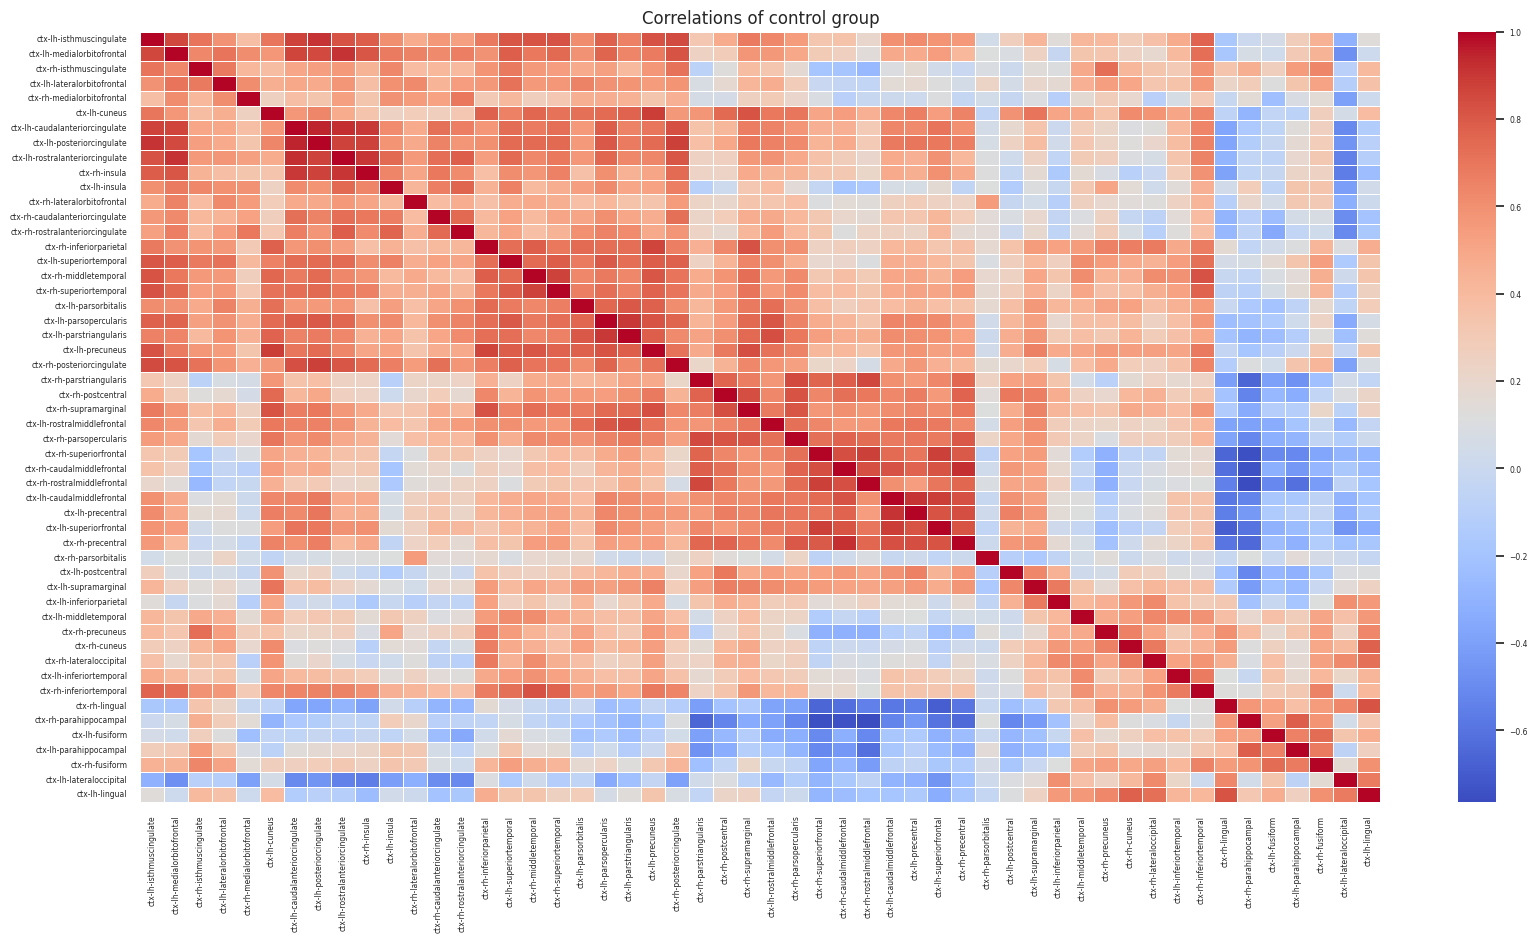

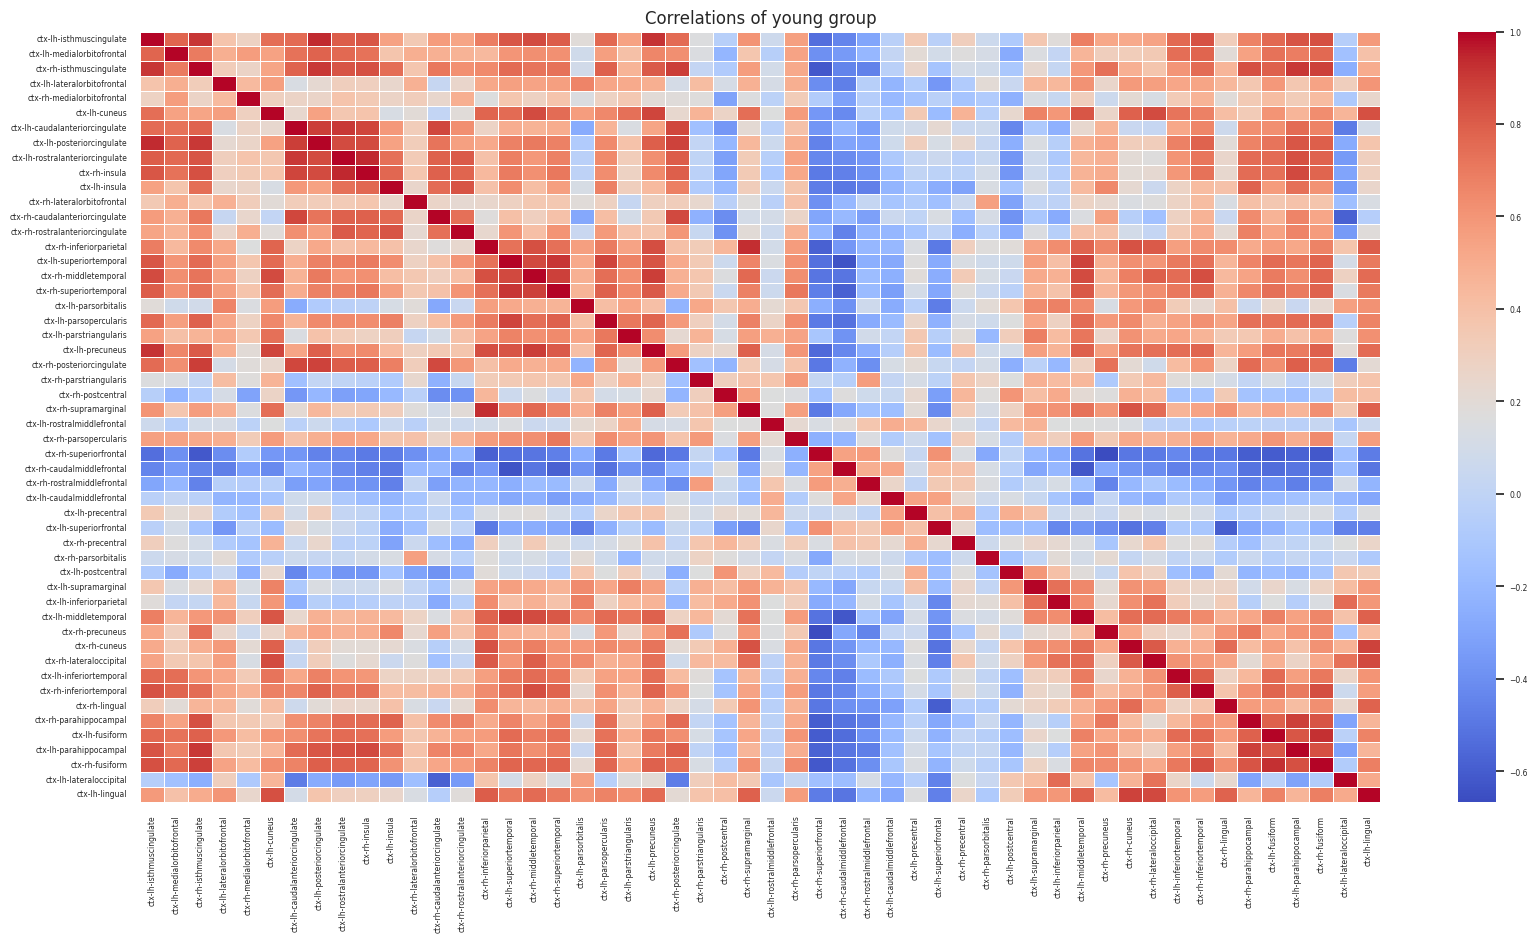

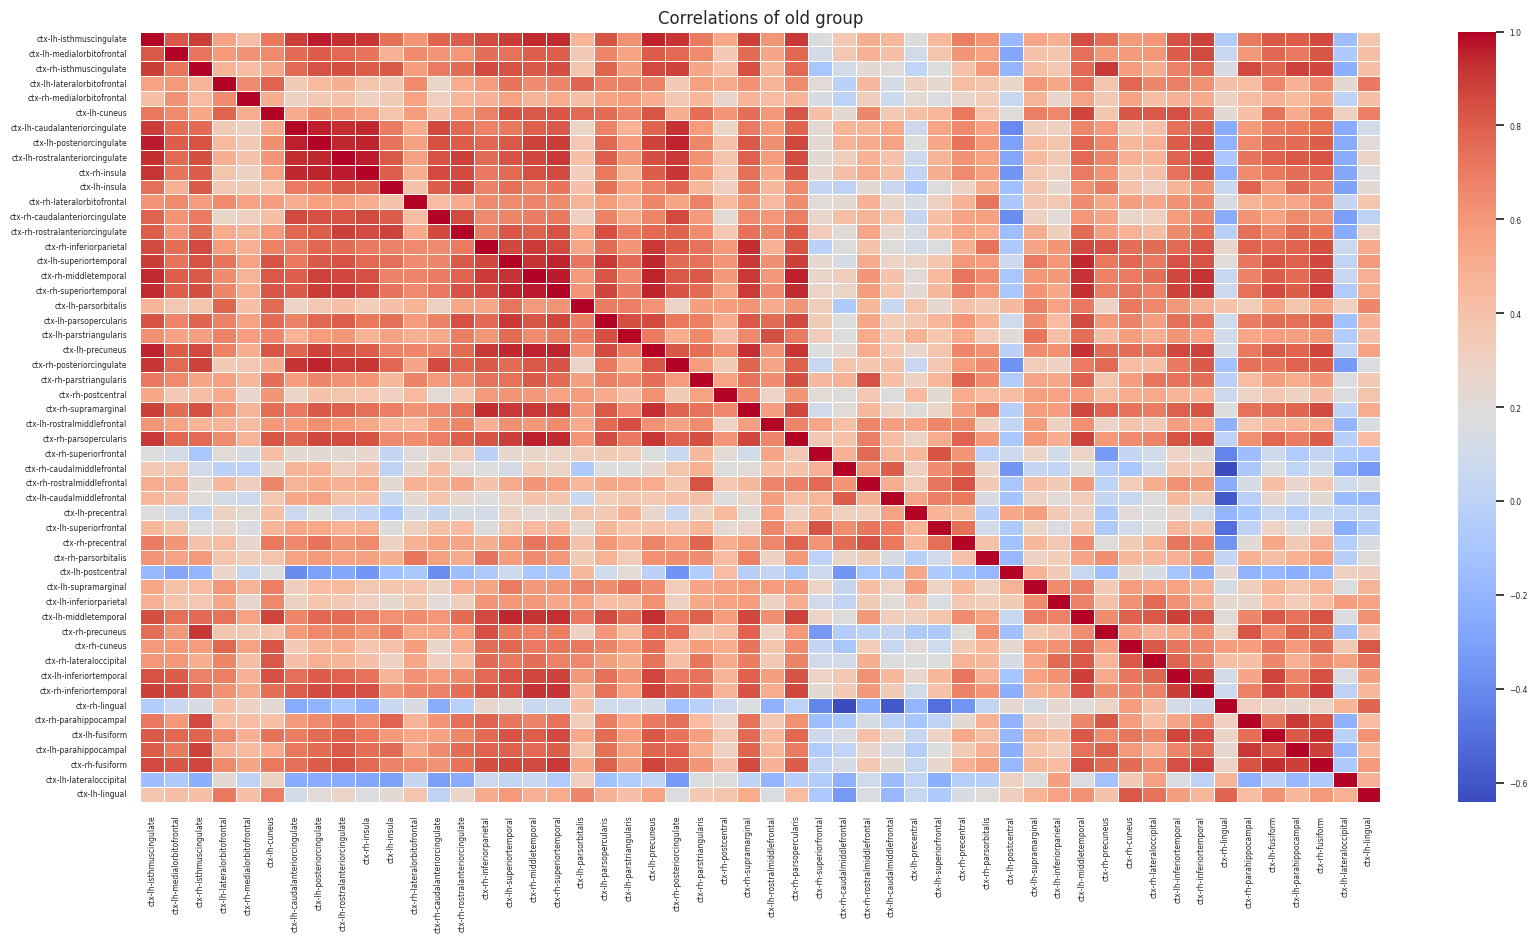

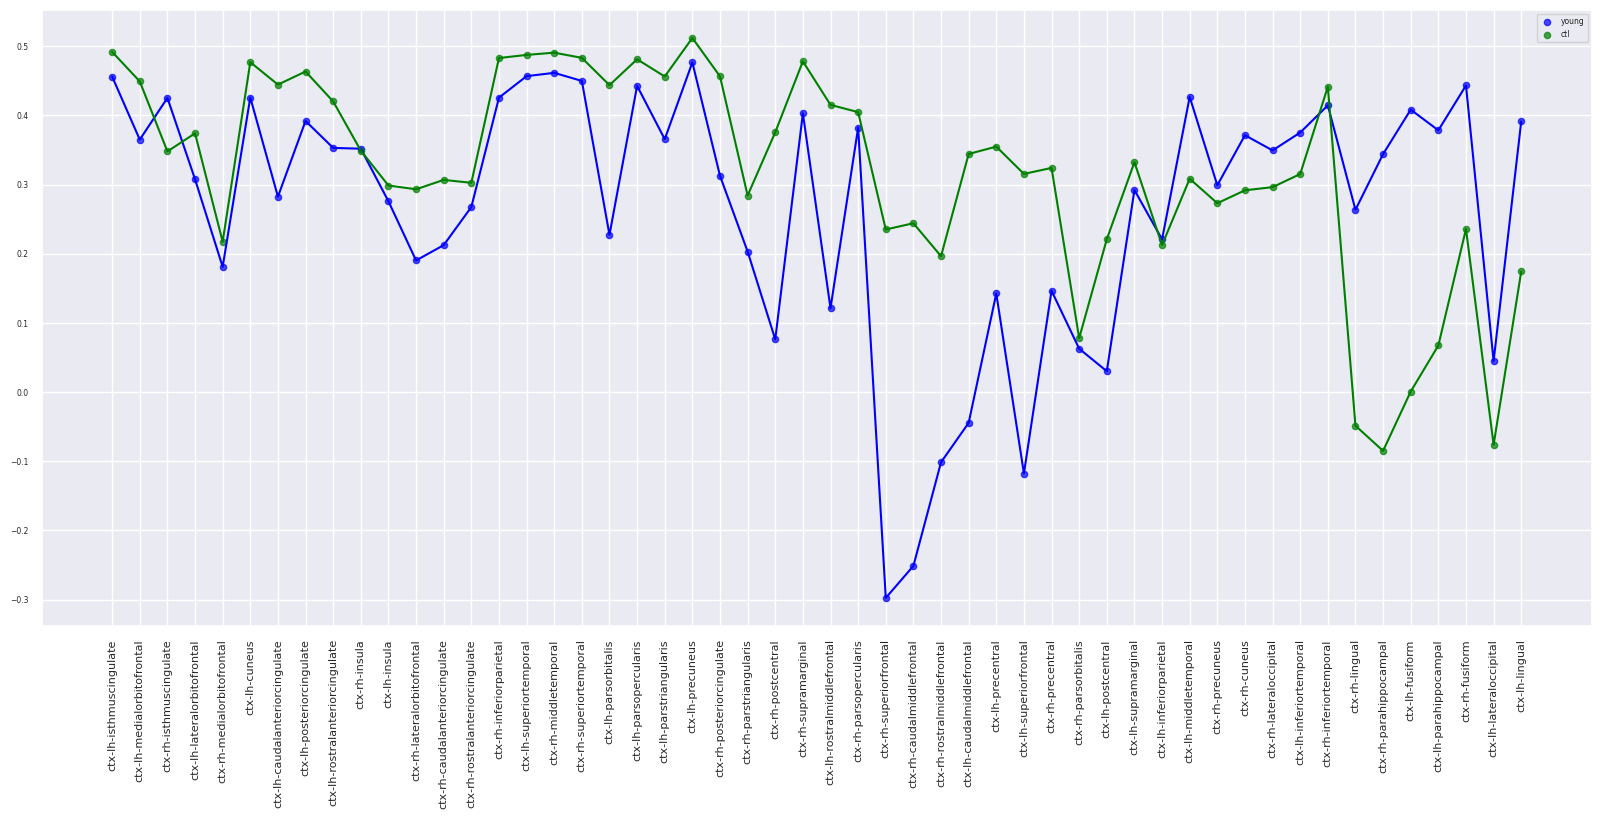

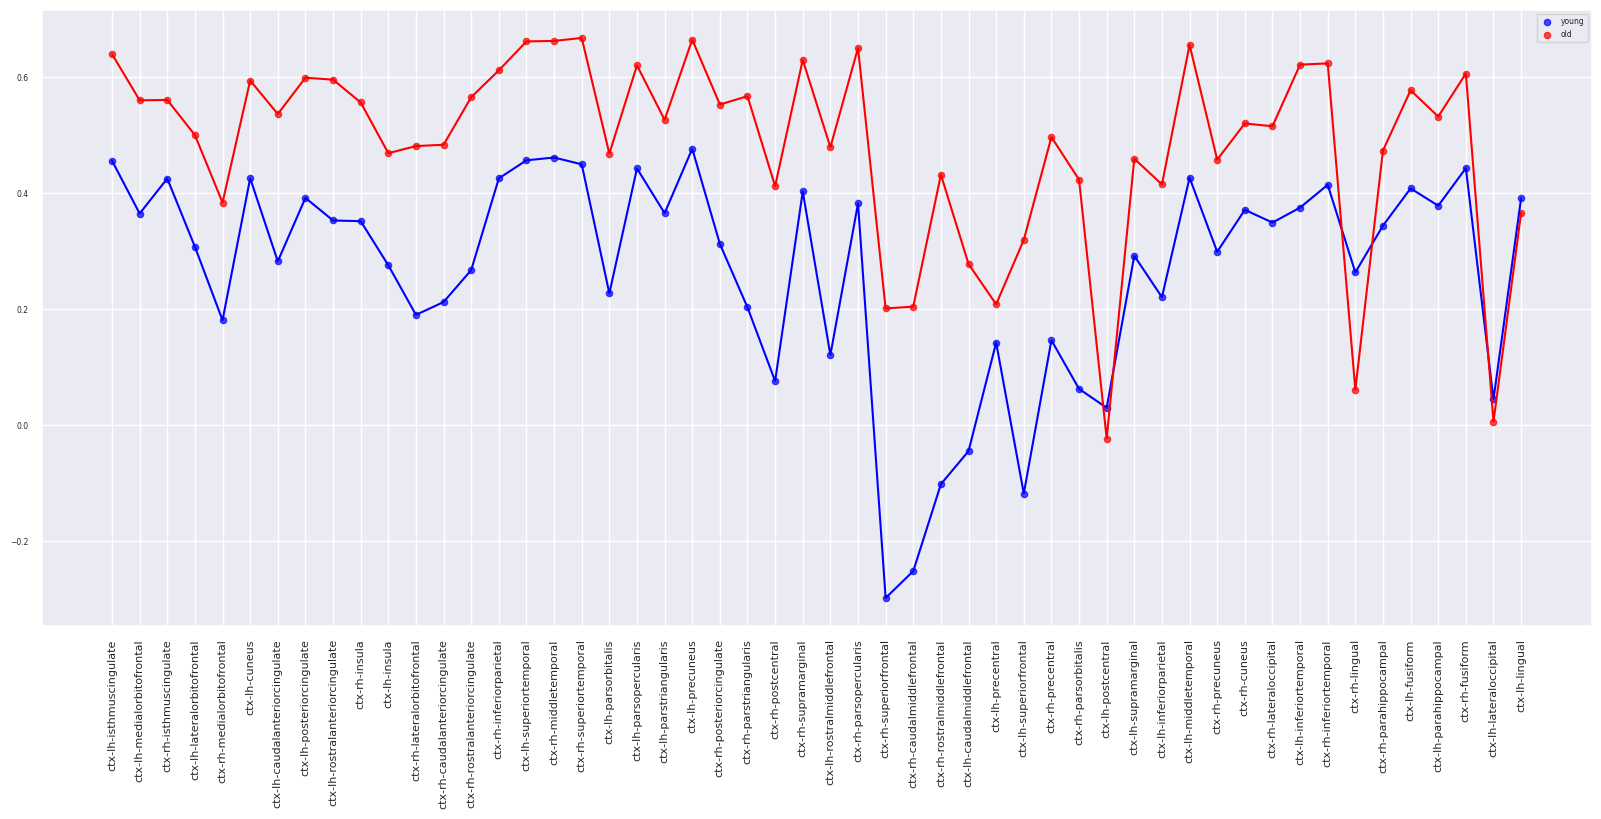

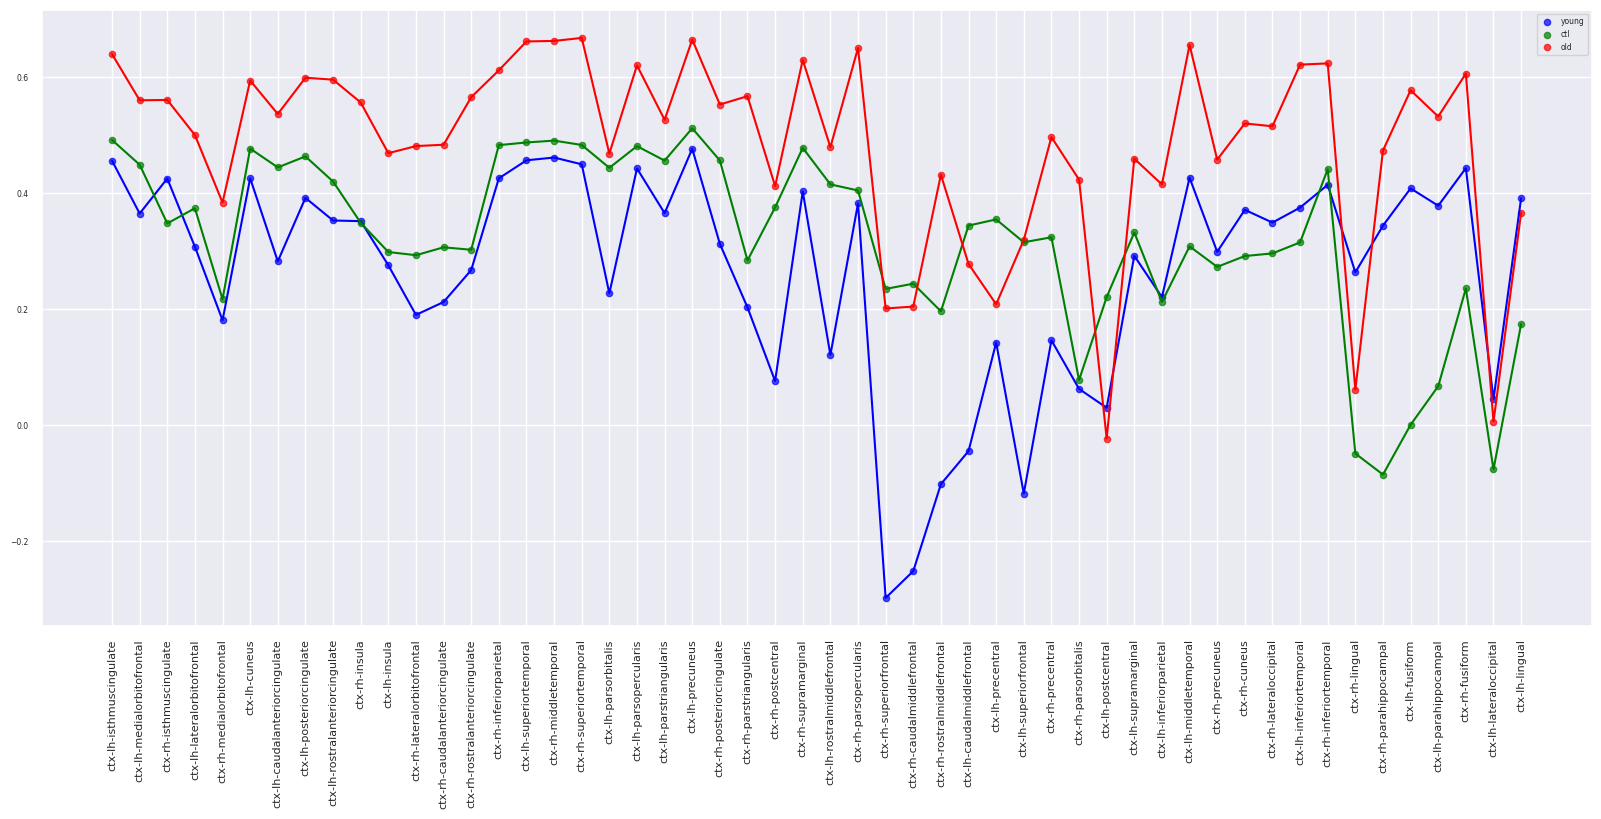

In [8]:
ctl_corr = StatisticsWrapper.roi_correlations(ctl_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of control group')

young_corr = StatisticsWrapper.roi_correlations(young_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of young group')
old_corr = StatisticsWrapper.roi_correlations(old_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of old group')

_ = show_corr_mean([(young_corr, 'young', 'blue'), (ctl_corr, 'ctl', 'green')], ctl_clustring_data)
_ = show_corr_mean([(young_corr, 'young', 'blue'), (old_corr, 'old', 'red')], ctl_clustring_data)
_ = show_corr_mean([(young_corr, 'young', 'blue'), (ctl_corr, 'ctl', 'green'), (old_corr, 'old', 'red')], ctl_clustring_data)


In [9]:
frobenius_norm = np.linalg.norm(young_distances - ctl_distances, 'fro')
print(f'Frobenius norm: {frobenius_norm}')

Frobenius norm: 10.280120968490454


## Boostraping

In [10]:
def bootstrap_correlation_matrices(df, rois_order, n_bootstrap=1000):
    """
    Perform bootstrapping on the correlation matrices.
    :param df: DataFrame containing the data.
    :param n_bootstrap: Number of bootstrap iterations.
    :return: Bootstrap samples of average correlation matrices.
    """
    subjects = df['subjects'].unique()
    n_subjects = len(subjects)
    n_regions = df['ROI'].nunique()
    bootstrap_samples = np.zeros((n_bootstrap, n_regions, n_regions))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        resampled_subjects = np.random.choice(subjects, n_subjects, replace=True)
        resampled_df = pd.DataFrame()

        for j, subject in enumerate(resampled_subjects):
            subject_data = df[df['subjects'] == subject].copy()
            # Create a unique identifier for the resampled subject
            subject_data['subjects'] = f"{subject}_resampled_{j}"
            resampled_df = pd.concat([resampled_df, subject_data], ignore_index=True)

        bootstrap_samples[i] = StatisticsWrapper.roi_correlations(resampled_df, params_to_work_with, rois_order,
                                                          group_title='', show=False).to_numpy()

    return bootstrap_samples

def analyze_bootstrap_results(bootstrap_samples):
    """
    Analyze bootstrap results to get summary statistics.
    :param bootstrap_samples: Bootstrap samples of average correlation matrices.
    :return: Mean and confidence intervals for the average correlation matrices.
    """
    mean_matrix = np.mean(bootstrap_samples, axis=0)
    lower_ci_matrix = np.percentile(bootstrap_samples, 2.5, axis=0)
    upper_ci_matrix = np.percentile(bootstrap_samples, 97.5, axis=0)
    
    return mean_matrix, lower_ci_matrix, upper_ci_matrix

In [11]:
young_bootstrap_corrs = bootstrap_correlation_matrices(young_ctx_data_z_score, ctl_clustring_data)
old_bootstrap_corrs = bootstrap_correlation_matrices(old_ctx_data_z_score, ctl_clustring_data)

In [17]:
young_mean_matrix, young_lower_ci, young_upper_ci = analyze_bootstrap_results(young_bootstrap_corrs)
old_mean_matrix, old_lower_ci, old_upper_ci = analyze_bootstrap_results(old_bootstrap_corrs)

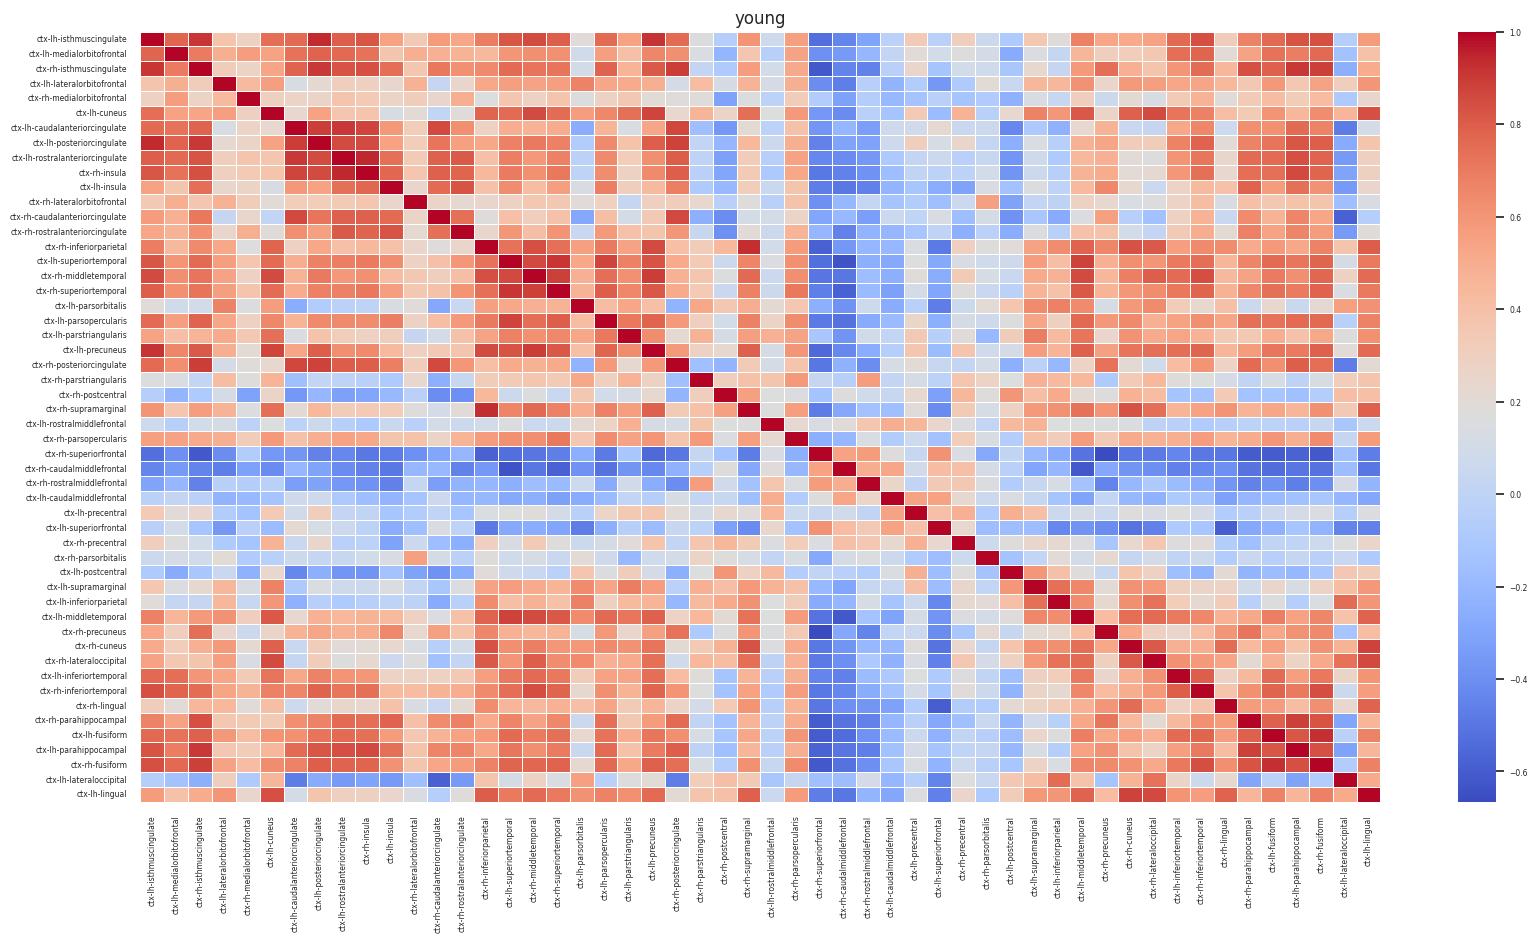

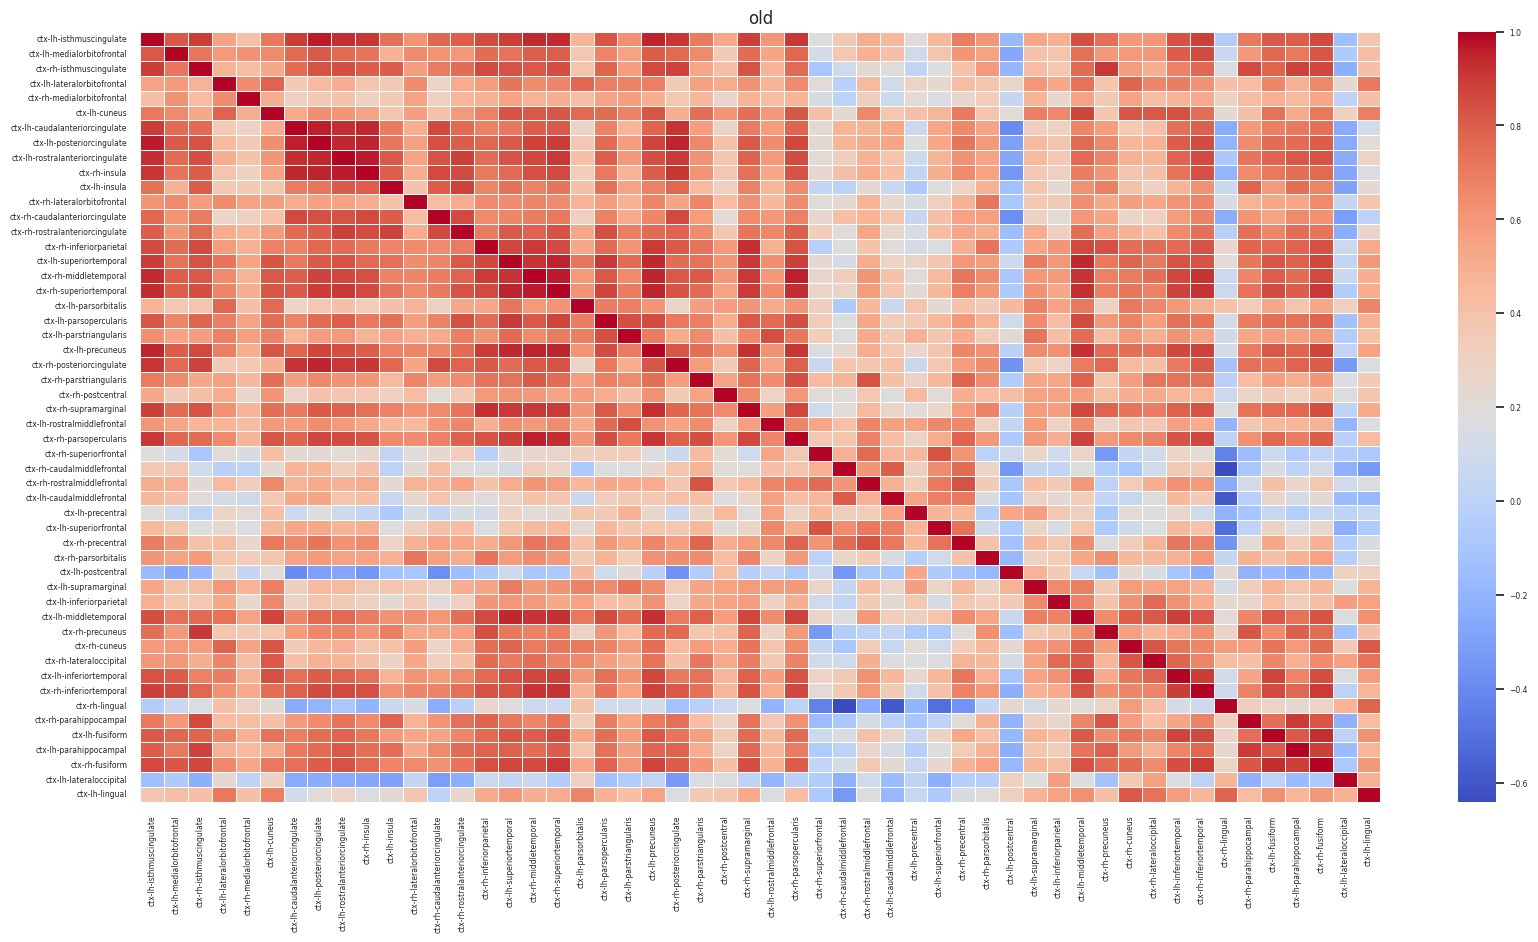

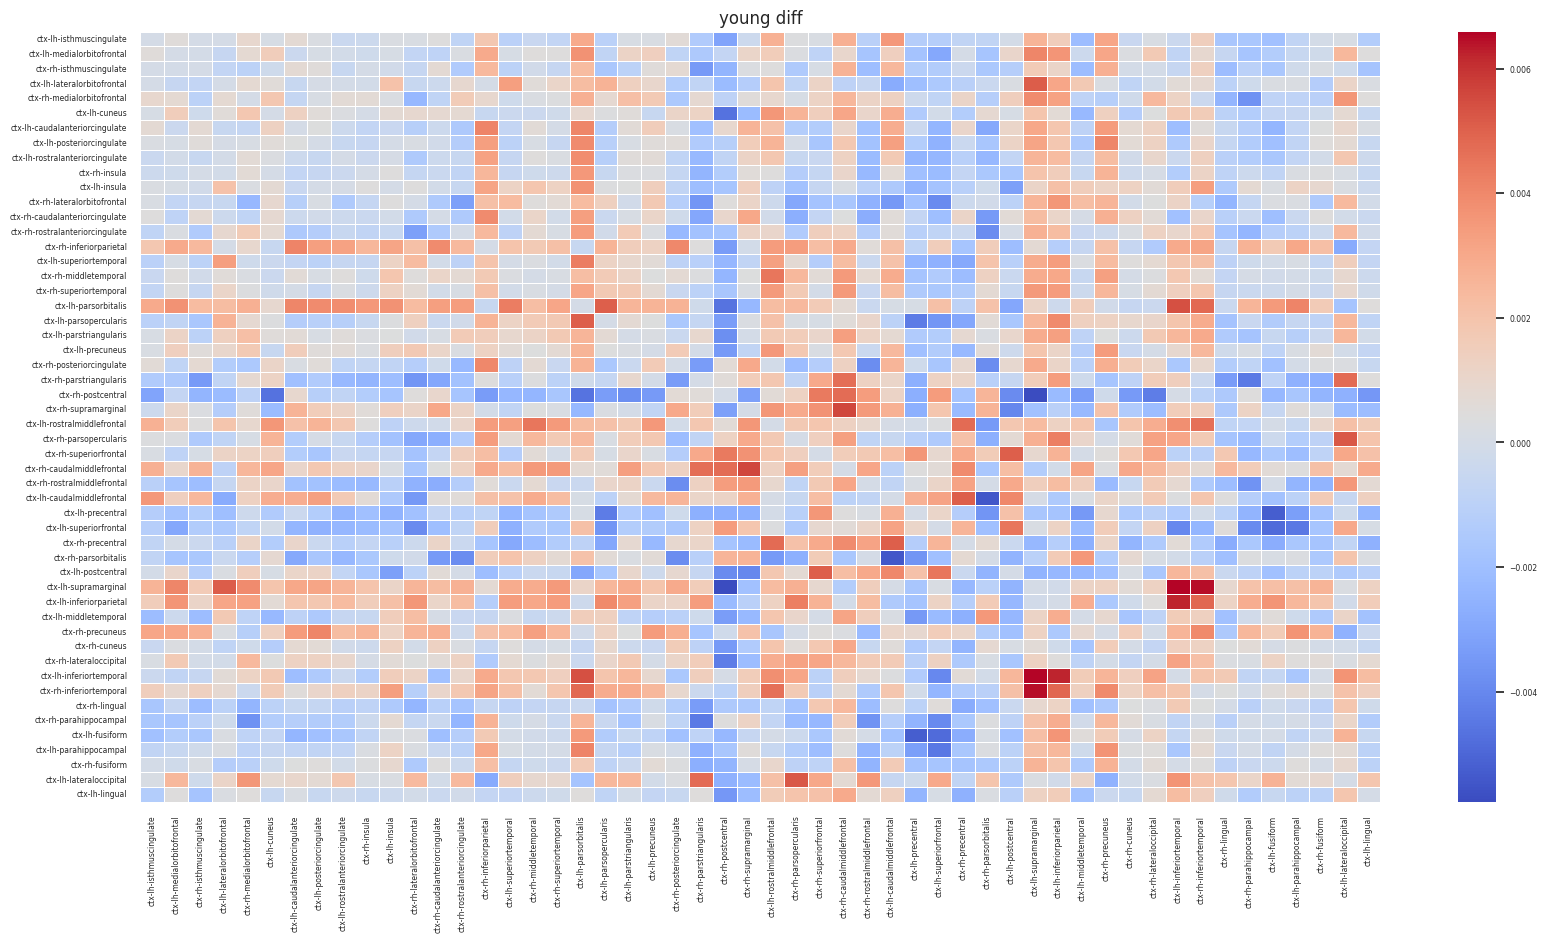

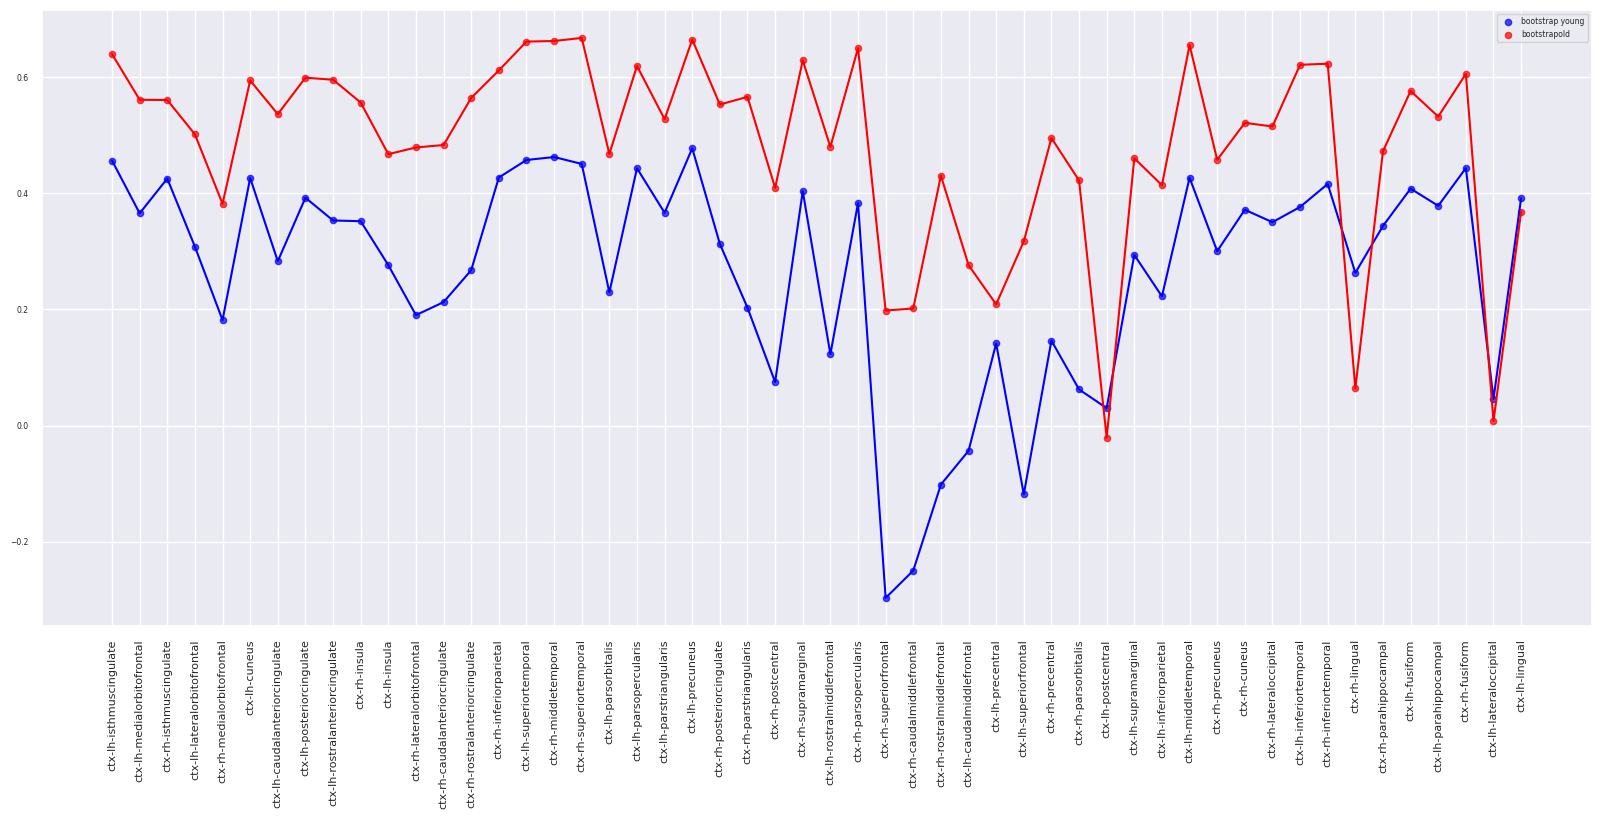

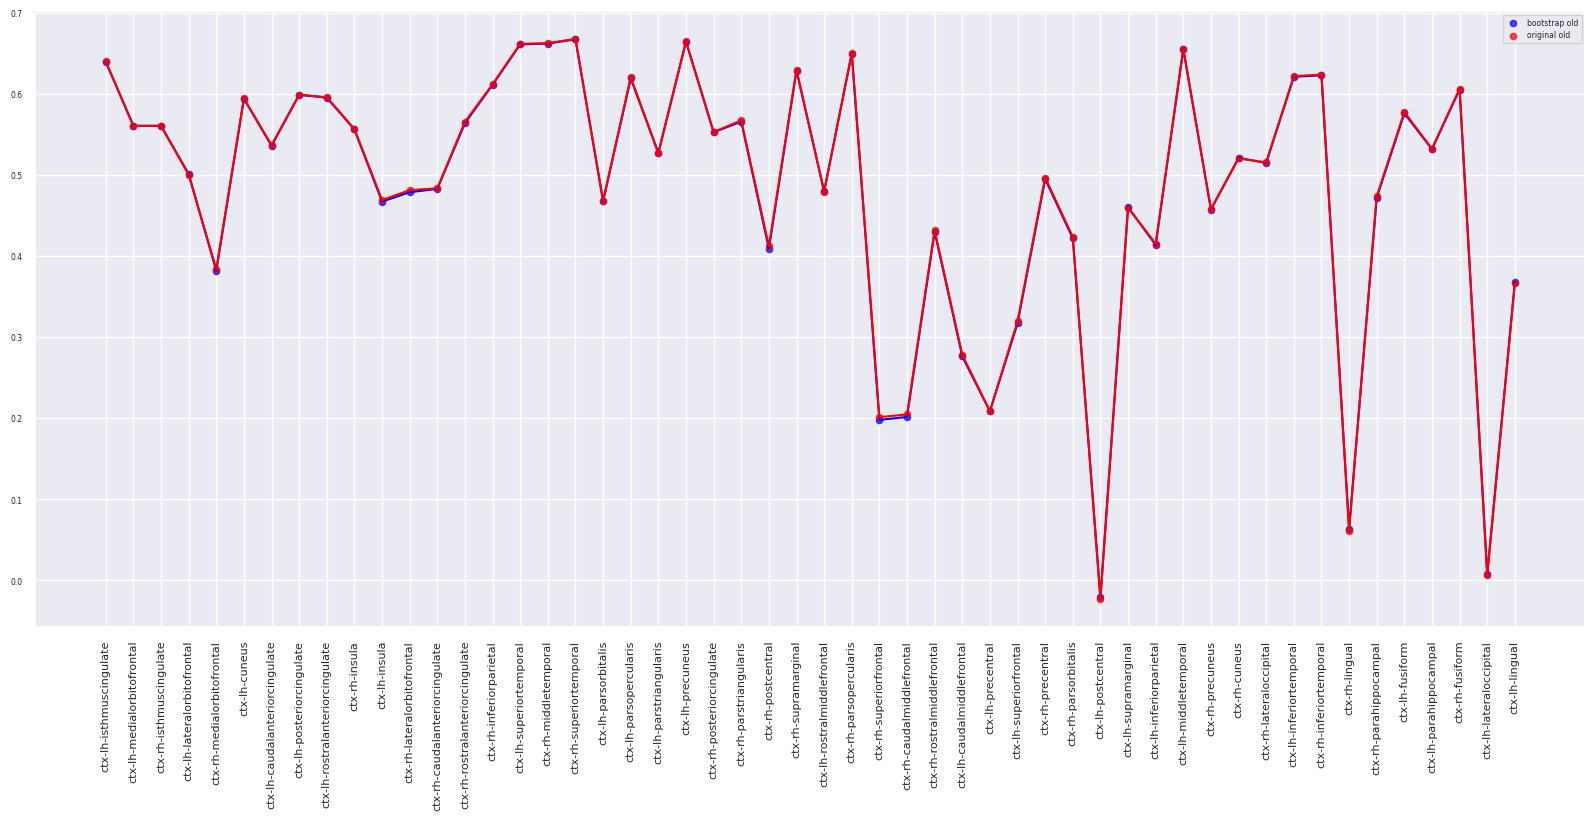

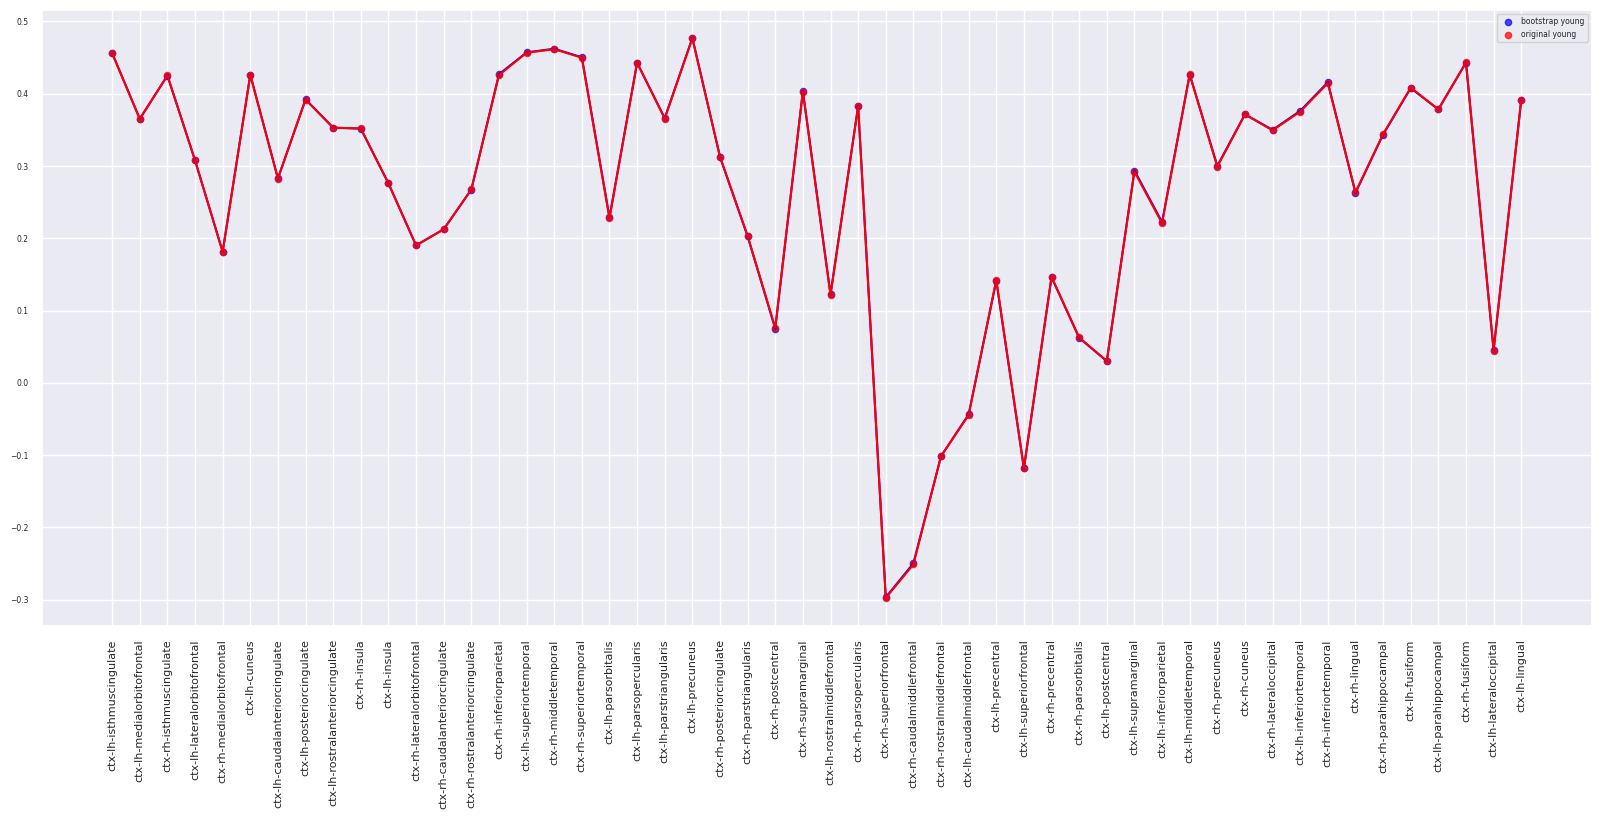

In [30]:
young_mean_df = pd.DataFrame(
            young_mean_matrix, index=ctl_clustring_data, columns=ctl_clustring_data)
old_mean_df = pd.DataFrame(
            old_mean_matrix, index=ctl_clustring_data, columns=ctl_clustring_data)
young_corr = StatisticsWrapper.roi_correlations(young_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='', show=False)
old_corr = StatisticsWrapper.roi_correlations(old_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='', show=False)

PlotsManager.plot_heatmap(young_mean_df, 'young')
PlotsManager.plot_heatmap(old_mean_df, 'old')
PlotsManager.plot_heatmap(young_mean_df-young_corr, 'young diff')

_ = show_corr_mean([(young_mean_df, 'bootstrap young', 'blue'), (old_mean_df, 'bootstrapold', 'red')], ctl_clustring_data)
_ = show_corr_mean([(old_mean_df, 'bootstrap old', 'blue'), (old_corr, 'original old', 'red')], ctl_clustring_data)
_ = show_corr_mean([(young_mean_df, 'bootstrap young', 'blue'), (young_corr, 'original young', 'red')], ctl_clustring_data)


In [24]:
young_mean_df

ctx-lh-isthmuscingulate   
ctx-lh-isthmuscingulate                         1.000000  \
ctx-lh-medialorbitofrontal                      0.778826   
ctx-rh-isthmuscingulate                         0.914022   
ctx-lh-lateralorbitofrontal                     0.378180   
ctx-rh-medialorbitofrontal                      0.281234   
ctx-lh-cuneus                                   0.745980   
ctx-lh-caudalanteriorcingulate                  0.754196   
ctx-lh-posteriorcingulate                       0.938438   
ctx-lh-rostralanteriorcingulate                 0.797964   
ctx-rh-insula                                   0.821947   
ctx-lh-insula                                   0.550076   
ctx-rh-lateralorbitofrontal                     0.343720   
ctx-rh-caudalanteriorcingulate                  0.571508   
ctx-rh-rostralanteriorcingulate                 0.530856   
ctx-rh-inferiorparietal                         0.691398   
ctx-lh-superiortemporal                         0.819160   
ctx-rh-middletemporal                           0.850629   
ctx-rh-superiortemporal                         0.798278   
ctx-lh-parsorbitalis                            0.192419   
ctx-lh-parsopercularis                          0.759080   
ctx-lh-parstriangularis                         0.547097   
ctx-lh-precuneus                                0.920358   
ctx-rh-posteriorcingulate                       0.754913   
ctx-rh-parstriangularis                         0.156247   
ctx-rh-postcentral                             -0.048836   
ctx-rh-supramarginal                            0.605621   
ctx-lh-rostralmiddlefrontal                     0.078169   
ctx-rh-parsopercularis                          0.551658   
ctx-rh-superiorfrontal                         -0.534120   
ctx-rh-caudalmiddlefrontal                     -0.438560   
ctx-rh-rostralmiddlefrontal                    -0.302054   
ctx-lh-caudalmiddlefrontal                     -0.026267   
ctx-lh-precentral                               0.341244   
ctx-lh-superiorfrontal                         -0.029322   
ctx-rh-precentral                               0.307999   
ctx-rh-parsorbitalis                            0.066238   
ctx-lh-postcentral                             -0.085978   
ctx-lh-supramarginal                            0.360079   
ctx-lh-inferiorparietal                         0.186144   
ctx-lh-middletemporal                           0.681040   
ctx-rh-precuneus                                0.527659   
ctx-rh-cuneus                                   0.509053   
ctx-rh-lateraloccipital                         0.541077   
ctx-lh-inferiortemporal                         0.763738   
ctx-rh-inferiortemporal                         0.838395   
ctx-rh-lingual                                  0.313164   
ctx-rh-parahippocampal                          0.668784   
ctx-lh-fusiform                                 0.762229   
ctx-lh-parahippocampal                          0.828346   
ctx-rh-fusiform                                 0.838835   
ctx-lh-lateraloccipital                        -0.052059   
ctx-lh-lingual                                  0.576402   

                                 ctx-lh-medialorbitofrontal   
ctx-lh-isthmuscingulate                            0.778826  \
ctx-lh-medialorbitofrontal                         1.000000   
ctx-rh-isthmuscingulate                            0.696291   
ctx-lh-lateralorbitofrontal                        0.491567   
ctx-rh-medialorbitofrontal                         0.569739   
ctx-lh-cuneus                                      0.546375   
ctx-lh-caudalanteriorcingulate                     0.729812   
ctx-lh-posteriorcingulate                          0.779956   
ctx-lh-rostralanteriorcingulate                    0.765190   
ctx-rh-insula                                      0.728179   
ctx-lh-insula                                      0.374216   
ctx-rh-lateralorbitofrontal                        0.487964   
ctx-rh-caudalanteriorcingulate   

In [25]:
young_corr

ctx-lh-isthmuscingulate   
ctx-lh-isthmuscingulate                         1.000000  \
ctx-lh-medialorbitofrontal                      0.778310   
ctx-rh-isthmuscingulate                         0.914018   
ctx-lh-lateralorbitofrontal                     0.378184   
ctx-rh-medialorbitofrontal                      0.280319   
ctx-lh-cuneus                                   0.745902   
ctx-lh-caudalanteriorcingulate                  0.753476   
ctx-lh-posteriorcingulate                       0.938211   
ctx-lh-rostralanteriorcingulate                 0.798397   
ctx-rh-insula                                   0.822268   
ctx-lh-insula                                   0.549846   
ctx-rh-lateralorbitofrontal                     0.343527   
ctx-rh-caudalanteriorcingulate                  0.571085   
ctx-rh-rostralanteriorcingulate                 0.531671   
ctx-rh-inferiorparietal                         0.689557   
ctx-lh-superiortemporal                         0.820160   
ctx-rh-middletemporal                           0.851089   
ctx-rh-superiortemporal                         0.798986   
ctx-lh-parsorbitalis                            0.189487   
ctx-lh-parsopercularis                          0.760086   
ctx-lh-parstriangularis                         0.546937   
ctx-lh-precuneus                                0.920171   
ctx-rh-posteriorcingulate                       0.754258   
ctx-rh-parstriangularis                         0.157638   
ctx-rh-postcentral                             -0.045758   
ctx-rh-supramarginal                            0.605955   
ctx-lh-rostralmiddlefrontal                     0.075472   
ctx-rh-parsopercularis                          0.551326   
ctx-rh-superiorfrontal                         -0.534329   
ctx-rh-caudalmiddlefrontal                     -0.441296   
ctx-rh-rostralmiddlefrontal                    -0.300990   
ctx-lh-caudalmiddlefrontal                     -0.029782   
ctx-lh-precentral                               0.342508   
ctx-lh-superiorfrontal                         -0.028102   
ctx-rh-precentral                               0.308754   
ctx-rh-parsorbitalis                            0.067014   
ctx-lh-postcentral                             -0.085917   
ctx-lh-supramarginal                            0.357486   
ctx-lh-inferiorparietal                         0.184647   
ctx-lh-middletemporal                           0.683143   
ctx-rh-precuneus                                0.524571   
ctx-rh-cuneus                                   0.509542   
ctx-rh-lateraloccipital                         0.540873   
ctx-lh-inferiortemporal                         0.764096   
ctx-rh-inferiortemporal                         0.836962   
ctx-rh-lingual                                  0.314838   
ctx-rh-parahippocampal                          0.670444   
ctx-lh-fusiform                                 0.764151   
ctx-lh-parahippocampal                          0.829124   
ctx-rh-fusiform                                 0.838870   
ctx-lh-lateraloccipital                        -0.052194   
ctx-lh-lingual                                  0.577721   

                                 ctx-lh-medialorbitofrontal   
ctx-lh-isthmuscingulate                            0.778310  \
ctx-lh-medialorbitofrontal                         1.000000   
ctx-rh-isthmuscingulate                            0.696338   
ctx-lh-lateralorbitofrontal                        0.492156   
ctx-rh-medialorbitofrontal                         0.568952   
ctx-lh-cuneus                                      0.544863   
ctx-lh-caudalanteriorcingulate                     0.730187   
ctx-lh-posteriorcingulate                          0.779839   
ctx-lh-rostralanteriorcingulate                    0.765272   
ctx-rh-insula                                      0.728400   
ctx-lh-insula                                      0.374109   
ctx-rh-lateralorbitofrontal                        0.488706   
ctx-rh-caudalanteriorcingulate   